In [ ]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split

In [4]:
# (Assuming data loading and model training are done as before)
# Load and preprocess data (recap)
data = pd.read_csv("heart_disease.csv")
# Format columns to be object-friendly format
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.head()

,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,...,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level,heart_disease_status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


In [5]:
data.columns

Index(['age', 'gender', 'blood_pressure', 'cholesterol_level',
       'exercise_habits', 'smoking', 'family_heart_disease', 'diabetes', 'bmi',
       'high_blood_pressure', 'low_hdl_cholesterol', 'high_ldl_cholesterol',
       'alcohol_consumption', 'stress_level', 'sleep_hours',
       'sugar_consumption', 'triglyceride_level', 'fasting_blood_sugar',
       'crp_level', 'homocysteine_level', 'heart_disease_status'],
      dtype='object')

## EDA

In [6]:
# Data size
print(f"Data size: {data.shape}")

Data size: (10000, 21)


In [7]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
age                       29
gender                    19
blood_pressure            19
cholesterol_level         30
exercise_habits           25
smoking                   25
family_heart_disease      21
diabetes                  30
bmi                       22
high_blood_pressure       26
low_hdl_cholesterol       25
high_ldl_cholesterol      26
alcohol_consumption     2586
stress_level              22
sleep_hours               25
sugar_consumption         30
triglyceride_level        26
fasting_blood_sugar       22
crp_level                 26
homocysteine_level        20
dtype: int64


Impute missing data using Decision Tree

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

pd.set_option('future.no_silent_downcasting', True)
def missforest_imputation(df):
    df_imputed = df.copy()
    
    # Dictionary to store label encoders for categorical columns
    label_encoders = {}
    
    # Iterate until all missing values are imputed or max iterations reached
    max_iter = 10
    iter_count = 0
    
    while df_imputed.isnull().sum().sum() > 0 and iter_count < max_iter:
        iter_count += 1
        prev_null_count = df_imputed.isnull().sum().sum()
        print(f"Iteration {iter_count}: {prev_null_count} missing values")
        for column in df_imputed.columns:
            # Skip if no missing values in this column
            if df_imputed[column].isnull().sum() == 0:
                continue
                
            # Create mask for rows where current column is missing
            mask = df_imputed[column].isnull()
            
            # Features for prediction (all except current)
            features = [col for col in df_imputed.columns if col != column]
            
            # Prepare training data
            X_train = df_imputed.loc[~mask, features].copy()
            y_train = df_imputed.loc[~mask, column].copy()
            
            # Prepare prediction data
            X_predict = df_imputed.loc[mask, features].copy()
            
            # Temporarily encode any string features for the model
            for feat in features:
                if pd.api.types.is_object_dtype(df_imputed[feat]):
                    # Create encoder if it doesn't exist for this column
                    if feat not in label_encoders:
                        label_encoders[feat] = LabelEncoder()
                        # Fit on non-null values
                        label_encoders[feat].fit(df_imputed[feat].dropna().astype(str))
                    
                    # Transform non-null values in both training and prediction sets
                    X_train.loc[X_train[feat].notna(), feat] = label_encoders[feat].transform(
                        X_train.loc[X_train[feat].notna(), feat].astype(str))
                    X_predict.loc[X_predict[feat].notna(), feat] = label_encoders[feat].transform(
                        X_predict.loc[X_predict[feat].notna(), feat].astype(str))
            
            # Fill remaining NAs with mean or mode - Fixed downcasting warning
            for feat in features:
                if pd.api.types.is_numeric_dtype(df_imputed[feat]):
                    fill_value = X_train[feat].mean()
                else:
                    fill_value = X_train[feat].mode()[0]
                
                # Add infer_objects to handle downcasting explicitly
                X_train[feat] = X_train[feat].fillna(fill_value).infer_objects(copy=False)
                X_predict[feat] = X_predict[feat].fillna(fill_value).infer_objects(copy=False)
            
            # Choose estimator based on data type
            if pd.api.types.is_numeric_dtype(df_imputed[column]):
                estimator = RandomForestRegressor(n_estimators=100, random_state=42)
                estimator.fit(X_train, y_train)
                predicted_values = estimator.predict(X_predict)
            else:
                # For categorical columns, encode target values
                if column not in label_encoders:
                    label_encoders[column] = LabelEncoder()
                    label_encoders[column].fit(df_imputed[column].dropna().astype(str))
                
                # Transform training data
                y_train_encoded = label_encoders[column].transform(y_train.astype(str))
                
                # Train classifier
                estimator = RandomForestClassifier(n_estimators=100, random_state=42)
                estimator.fit(X_train, y_train_encoded)
                
                # Predict and inverse transform back to original categories
                predicted_indices = estimator.predict(X_predict)
                predicted_values = label_encoders[column].inverse_transform(predicted_indices)
                
            # Fill in the missing values
            df_imputed.loc[mask, column] = predicted_values
        
        # Check if we're making progress
        current_null_count = df_imputed.isnull().sum().sum()
        print(f"Iteration {iter_count}: {current_null_count} missing values remaining")
        if current_null_count == prev_null_count:
            print("No progress made, stopping early.")
            break
    
    return df_imputed

# Check for imputed saved data
try:
    imputed_data = pd.read_csv("imputed_heart_disease.csv")
except FileNotFoundError:
    # Usage
    imputed_data = missforest_imputation(data)
    # Check for missing values
    missing_values_after = imputed_data.isnull().sum()
    print("Missing values after imputation:")
    print(missing_values_after[missing_values_after > 0])

In [9]:
imputed_data.head()

,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,...,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level,heart_disease_status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,126.46,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.00,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.00,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.00,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.00,10.381259,8.153887,No


In [10]:
imputed_data.to_csv("imputed_heart_disease.csv", index=False)

In [11]:
# Split the data into features and target
X = imputed_data.drop(columns=["heart_disease_status"])
y = imputed_data["heart_disease_status"]
# Encode categorical variables
le = LabelEncoder()
y = le.fit_transform(y)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (8000, 20), Testing set size: (2000, 20)


In [28]:
# Build the preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Separate regular categorical from ordinal columns
ordinal_cols = [col.lower().replace(" ", "_") for col in ['Exercise Habits', 'Alcohol Consumption', 'Sugar Consumption', 'Stress Level']]
# Get remaining categorical columns (excluding ordinal ones)
binary_cols = [col for col in X.select_dtypes(include=['object']).columns 
                           if col not in ordinal_cols and col != "gender"]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# All remaining categorical columns
categorical_cols = [col for col in X.select_dtypes(include=['object']).columns if col not in ordinal_cols and col not in binary_cols]

print(f"Ordinal columns: {ordinal_cols}")
print(f"Binary categorical columns: {binary_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Define ordinal categories with their order
ordinal_categories = [['Low', 'Medium', 'High'] for _ in range(len(ordinal_cols))]
binary_categories = [['No', 'Yes'] for _ in range(len(binary_cols))]

Ordinal columns: ['exercise_habits', 'alcohol_consumption', 'sugar_consumption', 'stress_level']
Binary categorical columns: ['smoking', 'family_heart_disease', 'diabetes', 'high_blood_pressure', 'low_hdl_cholesterol', 'high_ldl_cholesterol']
Numerical columns: ['age', 'blood_pressure', 'cholesterol_level', 'bmi', 'sleep_hours', 'triglyceride_level', 'fasting_blood_sugar', 'crp_level', 'homocysteine_level']
Categorical columns: ['gender']


In [65]:

from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import StandardScaler


numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=binary_categories))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=ordinal_categories))
])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        # ('num', StandardScaler(), numerical_cols),
        ('num', numeric_transformer, numerical_cols),
        ('binary', binary_transformer, binary_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        # ('cat', onehot_transformer, categorical_cols)
    ],
    remainder='drop'
)

tabnet_clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params=dict(
        mode="min",
        patience=10,
        min_lr=1e-5,
        factor=0.5,
    ),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    seed=42,
)

# Create a pipeline with preprocessing, PCA, and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', tabnet_clf)
])

# Fit the model
pipeline.fit(X_train, y_train)

/home/aphuc/ai/workspace/xdoc/.venv/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/aphuc/ai/workspace/xdoc/.venv/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.11187 |  0:00:00s
epoch 1  | loss: 0.57762 |  0:00:00s
epoch 2  | loss: 0.52499 |  0:00:01s
epoch 3  | loss: 0.51702 |  0:00:01s
epoch 4  | loss: 0.51423 |  0:00:02s
epoch 5  | loss: 0.50906 |  0:00:02s
epoch 6  | loss: 0.50547 |  0:00:02s
epoch 7  | loss: 0.50748 |  0:00:03s
epoch 8  | loss: 0.50192 |  0:00:03s
epoch 9  | loss: 0.50296 |  0:00:03s
epoch 10 | loss: 0.50627 |  0:00:04s
epoch 11 | loss: 0.5034  |  0:00:04s
epoch 12 | loss: 0.50124 |  0:00:04s
epoch 13 | loss: 0.50042 |  0:00:05s
epoch 14 | loss: 0.50046 |  0:00:05s
epoch 15 | loss: 0.50124 |  0:00:05s
epoch 16 | loss: 0.50116 |  0:00:06s
epoch 17 | loss: 0.49849 |  0:00:06s
epoch 18 | loss: 0.50105 |  0:00:06s
epoch 19 | loss: 0.50354 |  0:00:07s
epoch 20 | loss: 0.49973 |  0:00:07s
epoch 21 | loss: 0.49914 |  0:00:07s
epoch 22 | loss: 0.49976 |  0:00:08s
epoch 23 | loss: 0.49628 |  0:00:08s
epoch 24 | loss: 0.49687 |  0:00:08s
epoch 25 | loss: 0.49929 |  0:00:09s
epoch 26 | loss: 0.49713 |  0:00:09s
e

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'blood_pressure',
                                                   'cholesterol_level', 'bmi',
                                                   'sleep_hours',
                                                   'triglyceride_level',
                                                   'fasting_blood_sugar',
                                                   'crp_level',
                                                   'homocysteine_level']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_...
                                  clip_value=1,
                                  verbose=1,
                                  optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                  optimizer_params={'lr': 0.02},
                                  scheduler_fn=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>,
                                  scheduler_params={'factor': 0.5,
                                                    'min_lr': 1e-05,
                                                    'mode': 'min',
                                                    'patience': 10},
                                  mask_type='sparsemax',
                                  input_dim=19,
                                  output_dim=2,
                                  device_name='auto',
                                  n_shared_decoder=1,
                                  n_indep_decoder=1,
                                  grouped_features=[]))])

In [66]:
X_train

,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,low_hdl_cholesterol,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level
9254,78.0,Male,140.0,289.0,High,Yes,Yes,No,25.086206,Yes,Yes,No,Low,High,9.024681,Medium,222.0,137.0,14.481422,11.320909
1561,64.0,Male,143.0,203.0,Low,Yes,Yes,Yes,23.791361,Yes,Yes,No,High,Medium,6.543419,Medium,188.0,111.0,6.485267,15.761419
1670,18.0,Female,147.0,161.0,Low,Yes,Yes,Yes,37.100070,No,No,No,High,High,4.612469,Low,259.0,123.0,3.383982,14.664906
6087,24.0,Female,145.0,195.0,Medium,Yes,No,No,23.917206,Yes,No,No,Low,Medium,4.964663,High,175.0,101.0,9.998831,14.296107
6669,49.0,Male,157.0,291.0,Medium,Yes,No,Yes,22.477665,Yes,No,Yes,Low,Low,7.810732,Medium,261.0,99.0,3.111362,15.257110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,37.0,Male,168.0,221.0,Medium,No,Yes,No,18.751434,Yes,No,No,High,High,9.204600,High,385.0,145.0,11.497224,5.402544
5191,54.0,Female,156.0,261.0,High,No,No,No,27.909549,Yes,Yes,Yes,Medium,Medium,8.108505,Medium,343.0,138.0,12.966452,19.244289
5390,49.0,Female,144.0,228.0,Medium,No,Yes,No,33.563750,Yes,Yes,No,Low,High,7.650281,Low,106.0,159.0,13.646456,13.027824
860,22.0,Female,137.0,238.0,Low,Yes,No,No,23.752347,No,Yes,Yes,Medium,Medium,5.011020,High,214.0,92.0,3.374796,14.446374


In [67]:
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

model = pipeline.named_steps['classifier']
# Get feature names after preprocessing
predictions = model.predict(X_test_transformed)
# Test accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8020


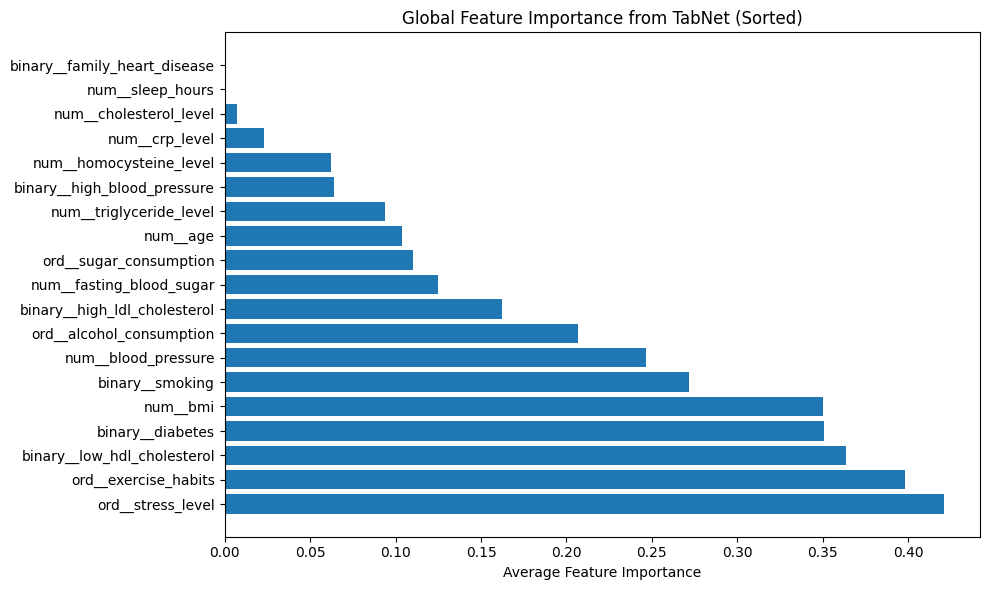

In [73]:
import matplotlib.pyplot as plt

explain_matrix, masks = model.explain(X_test_transformed)

# Calculate the global feature importance by averaging over all samples.
global_feature_importance = explain_matrix.mean(axis=0)

# Suppose feature_names is a list of your feature names.
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Plot global feature importance as a bar plot.
# Sort features by importance
sorted_indices = global_feature_importance.argsort()[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_importance = global_feature_importance[sorted_indices]

# Plot sorted global feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_importance)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Average Feature Importance")
plt.title("Global Feature Importance from TabNet (Sorted)")
plt.tight_layout()
plt.show()

In [87]:
import numpy as np

background_data = X_train.sample(n=100, random_state=42)

def predict_fn(data):
    """
    Accepts raw data (NumPy array or DataFrame), wraps it into a DataFrame
    with the correct columns, and returns pipeline.predict_proba output.
    """
    # If we got a NumPy array, convert it to DataFrame so ColumnTransformer can use column names
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=X_train.columns)
    # Now let the pipeline handle everything: preprocessing + model
    return pipeline.predict_proba(data)

explainer = shap.KernelExplainer(predict_fn, background_data)

In [ ]:
X_explain_df = X_test.iloc[:50]
shap_values = explainer.shap_values(X_explain_df)

In [95]:
shap_vals_pos = shap_values[:, :, 1]   # shape => (n_obs, n_features)

[[-0.01765176  0.01765176]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.01275723 -0.01275723]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.00742606  0.00742606]
 [-0.02141636  0.02141635]
 [-0.0063931   0.0063931 ]
 [ 0.00543201 -0.00543202]
 [ 0.          0.        ]
 [ 0.00607197 -0.00607197]
 [ 0.          0.        ]
 [ 0.0064036  -0.00640361]
 [ 0.          0.        ]
 [-0.01113035  0.01113035]
 [ 0.01209942 -0.01209943]
 [ 0.          0.        ]
 [ 0.          0.        ]]


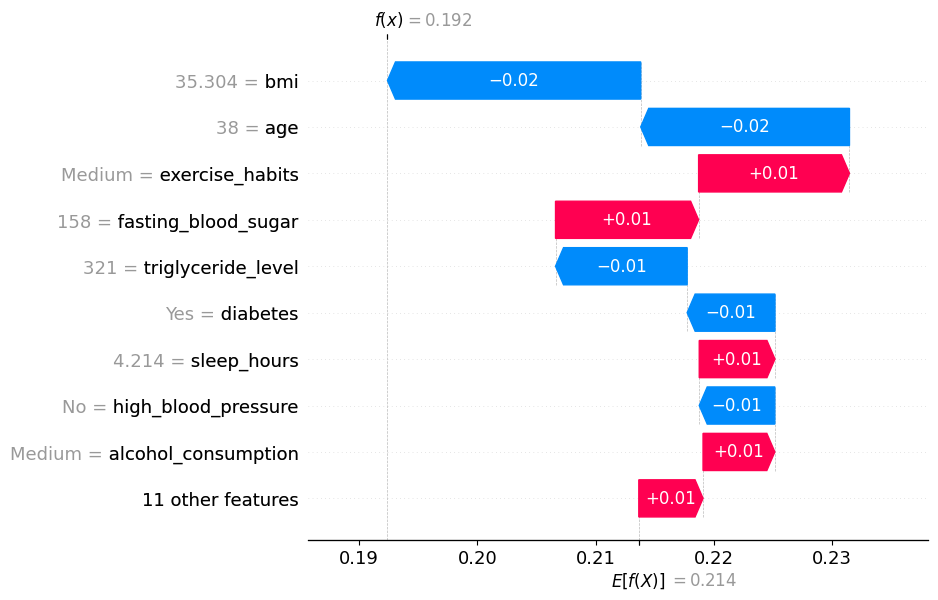

In [ ]:
# 1. Extract SHAP values for the positive class and the instance you want to explain:
#    shap_values has shape (n_obs, n_features, 2)
shap_vals_pos = shap_values[:, :, 0]
# 2. Choose the instance index you want to visualize (e.g., idx = 0)
idx = 0
instance_shap_values = shap_vals_pos[idx]             # shape: (n_features,)
instance_features = X_explain_df.iloc[idx]           # pandas Series of feature values

# 3. Get the base value (expected value) for the positive class:
base_value = explainer.expected_value[1]
shap.plots.waterfall(
    shap.Explanation(
        values=instance_shap_values,
        base_values=base_value,
        data=instance_features.values,
        feature_names=X_train.columns.tolist()
    )
)

In [ ]:
import os
from google import genai
from google.genai import types
from dotenv import load_dotenv
load_dotenv("key.env")

def generate(prompt):
    key = os.environ.get("GEMINI_API_KEY")
    if key is None:
        raise ValueError("Please set the GEMINI_API_KEY environment variable")
    client = genai.Client(
        api_key=os.environ.get("GEMINI_API_KEY"),
    )

    model = "gemini-2.0-flash"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        temperature=0.1,
        top_p=0.95,
        top_k=40,
        max_output_tokens=8192,
        response_mime_type="text/plain",
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        print(chunk.text, end="")

In [ ]:
# Create prompt
prompt = f"""
You are a medical assistant. Interpret the following SHAP values used to predict diabetes. Focus on features with the highest contributions (positive or negative).

Features:
- Glucose: 140 (SHAP: +0.50)
- BMI: 33.2 (SHAP: +0.15)
- Age: 45 (SHAP: -0.02)

Predicted risk: 0.85

Explain to the patient the significance of these features and their SHAP values in relation to their diabetes risk. Use simple language and provide a clear understanding of how these factors contribute to the prediction. Avoid technical jargon and ensure the explanation is patient-friendly.
"""

# Generate explanation
generate(prompt)

Okay, let's talk about your diabetes risk prediction. The system estimates your risk to be 0.85, which is quite high. We used some of your information to arrive at this number, and I want to explain what contributed the most to this prediction.

Think of it like this: we're trying to understand what's pushing your risk up or down.

*   **Glucose (140, SHAP: +0.50):** Your glucose level is a big factor pushing your risk *up*. A glucose level of 140 is higher than normal. The SHAP value of +0.50 means that this high glucose level significantly increases the likelihood of the prediction being positive for diabetes. In simpler terms, *your high blood sugar is a major reason why your risk is high.*

*   **BMI (33.2, SHAP: +0.15):** Your BMI, which is a measure of body fat based on your height and weight, is also contributing to a higher risk. A BMI of 33.2 falls into the obese category. The SHAP value of +0.15 indicates that this also increases the likelihood of the prediction being positiv

In [ ]:
import joblib

joblib.dump(pipeline, "heart_disease_model.pkl")
# Load the model
loaded_pipeline = joblib.load("heart_disease_model.pkl")
# Verify the loaded model
print(loaded_pipeline)
# Make predictions with the loaded model
predictions_loaded = loaded_pipeline.predict(X_test)
# Test accuracy
accuracy_loaded = accuracy_score(y_test, predictions_loaded)
print(f"Accuracy with loaded model: {accuracy_loaded:.4f}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['age', 'blood_pressure',
                                                   'cholesterol_level', 'bmi',
                                                   'sleep_hours',
                                                   'triglyceride_level',
                                                   'fasting_blood_sugar',
                                                   'crp_level',
                                                   'homocysteine_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')

In [ ]:
loaded_pipeline.named_steps["model"]